# Atomic Spectroscopy - Calculating Rydberg Constant
Date: 22/10/2025 

Author: Joshua Bowley 

Aim: This notebook analyses Neon calibration data to find the grating spacing and uses it to calculate Hydrogen wavelengths and the Rydberg constant.

In [279]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit

## 0. Experimental Parameters

All fixed values (screen distance, center position, etc.). 

Fundamental uncertainties (ruler resolutions, alignment errors, reference wavelength errors). 

In [282]:
# Fixed values:

center = 0.500 # position of center of screen ruler, in m
screen_distance = 1.000 # m
p = 1 # only first order diffracted lines are considered

In [284]:
# Fundamental Uncertainties: 

delta_l_meas = 1.723e-3 # total screen length uncertainty in meters
delta_d_meas = 7.141e-3 # total screed distance uncertainty in meters
delta_theta = np.radians(2) # angular uncertainty of screen in radians
delta_ref_wave = 0.01e-9 # uncertainty in reference wavelengths of neon green and yellow spectral lines

## 1. Calibration using neon

Using known reference wavelengths from NIST Atomic Spectra Database (Ne I): 

585.25 nm (yellow) and 540.06 nm (green)

In [287]:
# Create a pandas DataFrame of measured data 
neon_df = pd.DataFrame({
    "colour": ["yellow_L", "yellow_R", "green_L", "green_R"],
    "position_m": [100e-3, 858e-3, 138e-3, 832e-3],
    "wavelength_m": [585.25e-9, 585.25e-9, 540.06e-9, 540.06e-9]
})

In [288]:
# Calculate screen length and its uncertainty
neon_df["l_m"] = np.abs(neon_df["position_m"] - center)
neon_df["delta_l_m"] = neon_df["l_m"] * np.tan(delta_theta)

In [289]:
# Calculate sin(alpha) and its uncertainty
# Intermediate calculations for clarity
l_sq_plus_D_sq = neon_df["l_m"]**2 + screen_distance**2
denominator_32 = l_sq_plus_D_sq ** (1.5)

In [290]:
# Partial derivatives for sin(alpha)
d_sin_dl = (screen_distance**2) / denominator_32
d_sin_dD = (-neon_df["l_m"] * screen_distance) / denominator_32

In [291]:
# Propagate uncertainties for sin(alpha)
variance_from_l = (d_sin_dl * neon_df["delta_l_m"])**2
variance_from_D = (d_sin_dD * delta_d_meas)**2
neon_df["sin(alpha)"] = neon_df["l_m"] / np.sqrt(l_sq_plus_D_sq)
neon_df["delta_sin(alpha)"] = np.sqrt(variance_from_l + variance_from_D)

In [367]:
# Calculate grating spacing d_g
neon_df["d_g_m"] = p * neon_df["wavelength_m"] / neon_df["sin(alpha)"]

In [293]:
# Intermediate calculations for d_g uncertainty
d_dg_dlambda = 1 / neon_df["sin(alpha)"]
d_dg_dsinalpha = -neon_df["wavelength_m"] / (neon_df["sin(alpha)"]**2)

In [294]:
# Propagate uncertainties for d_g
variance_from_wavelength = (d_dg_dlambda * delta_ref_wave)**2
variance_from_sinalpha = (d_dg_dsinalpha * neon_df["delta_sin(alpha)"])**2
neon_df["delta_d_g_m"] = np.sqrt(variance_from_wavelength + variance_from_sinalpha)

In [295]:
# Display with column-specific formats
display(
    neon_df.style.format({
        "position_m": "{:.4f}",
        "wavelength_m": "{:.6e}",
        "l_m": "{:.4f}",
        "delta_l_m": "{:.6f}",
        "sin(alpha)": "{:.8f}",
        "delta_sin(alpha)": "{:.8e}",
        "d_g_m": "{:.8e}",
        "delta_d_g_m": "{:.8e}"
    })
)

,colour,position_m,wavelength_m,l_m,delta_l_m,sin(alpha),delta_sin(alpha),d_g_m,delta_d_g_m
0,yellow_L,0.1000,5.852500e-07,0.4000,0.013968,0.37139068,1.14117562e-02,1.57583385e-06,4.84208022e-08
1,yellow_R,0.8580,5.852500e-07,0.3580,0.012502,0.33705200,1.06488853e-02,1.73637896e-06,5.48594965e-08
2,green_L,0.1380,5.400600e-07,0.3620,0.012641,0.34038375,1.07267657e-02,1.58662098e-06,5.00003728e-08
3,green_R,0.8320,5.400600e-07,0.3320,0.011594,0.31508866,1.01158328e-02,1.71399375e-06,5.50272959e-08


Now, I am going to use the experimental values for $d_g$ and propogated uncertainties $\delta d_g$ to calculate a weighted mean value for $d_{g,\text{mean}}$. This means that calculated values with smaller uncertainty will be favoured, and therefore the calibrated diffraction grating constant should be more accurate. 

In [297]:
# Calculate weighted mean of d_g (weighted by 1/uncertainty^2)
weights = 1 / neon_df["delta_d_g_m"]**2
d_g_weighted_mean = np.sum(weights * neon_df["d_g_m"]) / np.sum(weights)

In [298]:
# Uncertainty in weighted mean (standard error of weighted mean)
delta_d_g_weighted_mean = 1 / np.sqrt(np.sum(weights))
print(f"Weighted mean grating spacing: {d_g_weighted_mean:.4g} ± {delta_d_g_weighted_mean:.4g} m")

Weighted mean grating spacing: 1.645e-06 ± 2.591e-08 m


I will also calculate a simple (unweighted mean) for comparison. In the case of a simple mean, the uncertainties can be given by: 

$$\delta_{\bar{x}} = \frac{s}{\sqrt{N}}$$

where $s$ = sample standard deviation, and $N$ = number of measurements. 

In [300]:
# Calculate simple (unweighted) mean for comparison
d_g_mean_m = np.mean(neon_df["d_g_m"])
delta_d_g_mean_m = np.std(neon_df["d_g_m"], ddof=1) / np.sqrt(len(neon_df))

In [301]:
print(f"Weighted mean grating spacing: {d_g_weighted_mean:.4g} ± {delta_d_g_weighted_mean:.4g} m")
print(f"Mean grating spacing: {d_g_mean_m:.3e} ± {delta_d_g_mean_m:.4g} m")

Weighted mean grating spacing: 1.645e-06 ± 2.591e-08 m
Mean grating spacing: 1.653e-06 ± 4.187e-08 m


Both weighted and unweighted mean grating spacing lie within the other's uncertainty values, further validating these experimental values. 

## 2. Hydrogen Spectrum 

In [304]:
# Create a pandas DataFrame of measured data 

hydrogen_df = pd.DataFrame({
    "colour": ["red_La", "red_Lb", "red_Ra", "red_Rb", "green_La", "green_Lb", "green_Ra", "green_Rb", "blue_L", "blue_R"],
    "position_m": [39e-3, 50e-3, 906e-3, 948e-3, 165e-3, 179e-3, 790e-3, 825e-3, 218e-3, 788e-3],
})

In [305]:
# Calculate screen length and its uncertainty
hydrogen_df["l_m"] = np.abs(hydrogen_df["position_m"] - center)
hydrogen_df["delta_l_m"] = hydrogen_df["l_m"] * np.tan(delta_theta)

In [306]:
# Calculate sin(alpha) and its uncertainty
# Intermediate calculations for clarity
H_l_sq_plus_D_sq = hydrogen_df["l_m"]**2 + screen_distance**2
H_denominator_32 = H_l_sq_plus_D_sq ** (1.5)

In [307]:
# Partial derivatives for sin(alpha)
H_d_sin_dl = (screen_distance**2) / H_denominator_32
H_d_sin_dD = (-hydrogen_df["l_m"] * screen_distance) / H_denominator_32

In [308]:
# Propagate uncertainties for sin(alpha)
H_variance_from_l = (H_d_sin_dl * hydrogen_df["delta_l_m"])**2
H_variance_from_D = (H_d_sin_dD * delta_d_meas)**2
hydrogen_df["sin(alpha)"] = hydrogen_df["l_m"] / np.sqrt(H_l_sq_plus_D_sq)
hydrogen_df["delta_sin(alpha)"] = np.sqrt(H_variance_from_l + H_variance_from_D)

I am choosing to use the weighted mean grating specing, as I value the statistical accuracy gained by weighing the mean by the uncertainties. The difference between the two choices is similar, with the unweighted mean having a larger uncertainty.

In [310]:
# Calculate wavelength and its uncertainty
hydrogen_df["wavelength_m"] = d_g_weighted_mean * hydrogen_df["sin(alpha)"]

In [311]:
# Propogate uncertainties for wavelength_a
H_variance_from_d_g = (hydrogen_df["sin(alpha)"] * delta_d_g_weighted_mean)**2
H_variance_from_sin_a = (d_g_weighted_mean * hydrogen_df["delta_sin(alpha)"])**2
hydrogen_df["delta_wavelength_m"] = np.sqrt(H_variance_from_d_g + H_variance_from_sin_a)

In [312]:
# Display with column-specific formats
display(
    hydrogen_df.style.format({
        "position_m": "{:.4f}",
        "l_m": "{:.4f}",
        "delta_l_m": "{:.6f}",
        "sin(alpha)": "{:.4g}",
        "delta_sin(alpha)": "{:.4g}",
        "wavelength_m": "{:.3e}",
        "delta_wavelength_m": "{:.3e}"
    })
)

,colour,position_m,l_m,delta_l_m,sin(alpha),delta_sin(alpha),wavelength_m,delta_wavelength_m
0,red_La,0.0390,0.4610,0.016098,0.4187,0.01231,6.888e-07,2.297e-08
1,red_Lb,0.0500,0.4500,0.015714,0.4104,0.01216,6.751e-07,2.266e-08
2,red_Ra,0.9060,0.4060,0.014178,0.3762,0.01151,6.189e-07,2.130e-08
3,red_Rb,0.9480,0.4480,0.015645,0.4088,0.01214,6.726e-07,2.260e-08
4,green_La,0.1650,0.3350,0.011698,0.3176,0.01018,5.226e-07,1.866e-08
5,green_Lb,0.1790,0.3210,0.011210,0.3056,0.009876,5.028e-07,1.808e-08
6,green_Ra,0.7900,0.2900,0.010127,0.2785,0.009157,4.582e-07,1.671e-08
7,green_Rb,0.8250,0.3250,0.011349,0.3091,0.009964,5.085e-07,1.825e-08
8,blue_L,0.2180,0.2820,0.009848,0.2714,0.008961,4.465e-07,1.634e-08
9,blue_R,0.7880,0.2880,0.010057,0.2768,0.009109,4.553e-07,1.661e-08


## 3. Determination of Rydberg Constant 

I identified the hydrogen spectral lines by comparing my measured wavelengths to the known Balmer series transitions:

- Red lines (~655-660 nm) → n = 3 → 2 transition ($H$ - $\alpha$)
- Green lines (~490 nm) → n = 4 → 2 transition ($H$ - $\beta$)  
- Blue lines (~435 nm) → n = 5 → 2 transition ($H$ - $\gamma$)

This assignment follows from the Rydberg formula - larger n values give longer wavelengths (redder light), and my measured wavelengths match the expected order for the Balmer series (transitions to n=2).

Now I will calculate the Rydberg constant using the Balmer series formula and weighted linear regression. 

In [315]:
# Add n values based on colour mapping
n_map = {
    "red_La": 3, "red_Lb": 3, "red_Ra": 3, "red_Rb": 3,
    "green_La": 4, "green_Lb": 4, "green_Ra": 4, "green_Rb": 4,
    "blue_L": 5, "blue_R": 5
}

In [316]:
hydrogen_df["n"] = hydrogen_df["colour"].map(n_map)

In [317]:
# Calculate weighted statistics for each n group
n_vals = hydrogen_df["n"].unique()
results = []

In [318]:
for n in n_vals:
    group = hydrogen_df[hydrogen_df["n"] == n]
    weights = 1 / group["delta_wavelength_m"]**2
    weighted_mean = np.sum(weights * group["wavelength_m"]) / np.sum(weights)
    weighted_uncertainty = 1 / np.sqrt(np.sum(weights))
    count = len(group)

    results.append({
        "n": n,
        "wavelength_mean": weighted_mean, 
        "delta_wavelength_mean": weighted_uncertainty, 
        "measurement_count": count 
    })

balmer_df = pd.DataFrame(results)
display(balmer_df)

,n,wavelength_mean,delta_wavelength_mean,measurement_count
0,3,6.622607e-07,1.117774e-08,4
1,4,4.959622e-07,8.937450e-09,4
2,5,4.508466e-07,1.164794e-08,2


Now I will calculate the Rydberg constant using the Balmer formula and weighted linear regression. 

In [371]:
# Calulate y = 1/lambda and propogate uncertainty
balmer_df["y"] = 1 / balmer_df["wavelength_mean"]
balmer_df["delta_y"] = balmer_df["delta_wavelength_mean"] / balmer_df["wavelength_mean"]**2

In [390]:
# Calculate x = (1/2^2 - 1/n^2) 
balmer_df["x"] = (1/4) - (1 / balmer_df["n"]**2)

In [392]:
# Display with column specific formatting: 
display(balmer_df.style.format({
    'wavelength_mean': '{:.3e}',
    'delta_wavelength_mean': '{:.3e}', 
    'y': '{:.0f}',
    'y_err': '{:.0f}',
    'x': '{:.4f}'
}))

,n,wavelength_mean,delta_wavelength_mean,measurement_count,y,delta_y,x
0,3,6.623e-07,1.118e-08,4,1509979,25485.660568,0.1389
1,4,4.960e-07,8.937e-09,4,2016283,36334.277585,0.1875
2,5,4.508e-07,1.165e-08,2,2218049,57304.893999,0.2100


Now I will perform weighted linear regression to determine the Rydberg Constant. 

In [395]:
# Linear regression model for fitting
def linear_model(x, R_H):
    return R_H * x

In [416]:
# Perform weighted linear regression
popt, pcov = curve_fit(linear_model, balmer_df["x"], balmer_df["y"],
                       sigma = balmer_df["delta_y"], absolute_sigma=True, p0=1.1e7) # initial guess R_H accepted value

In [399]:
R_H_best = popt[0]
R_H_err = np.sqrt(pcov[0][0])

In [401]:
print(f"Experimental Rydberg Constant: R_H = {R_H_best:.0f} ± {R_H_err:.0f} m⁻¹")
print(f"Accepted R_H = 10973731.6 m⁻¹")
print(f"Percentage difference: {((R_H_best - 10973731.6)/10973731.6*100):.2f}%")

Experimental Rydberg Constant: R_H = 10767051 ± 119730 m⁻¹
Accepted R_H = 10973731.6 m⁻¹
Percentage difference: -1.88%


Finally, I will plot to visualise the linear relationship and fit quality. 

In [404]:
# Generate fit line and create plot
x_fit = np.linspace(balmer_df['x'].min() * 0.8, balmer_df['x'].max() * 1.1, 100)
y_fit = linear_model(x_fit, R_H_best)

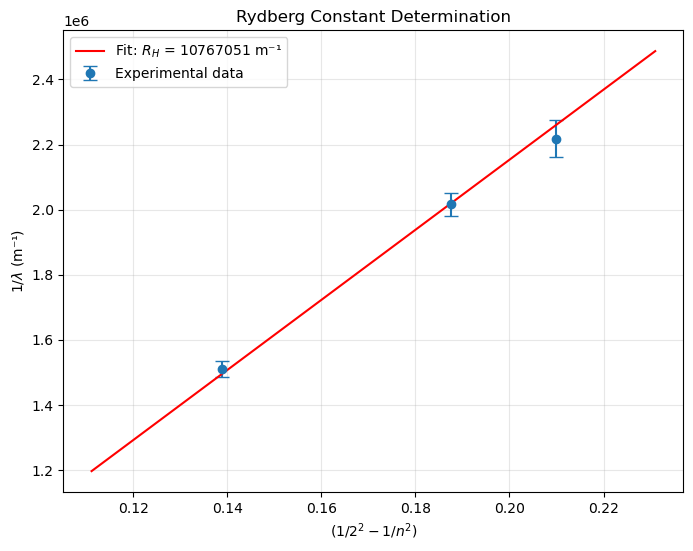

In [410]:
plt.figure(figsize=(8, 6))
plt.errorbar(balmer_df['x'], balmer_df['y'], yerr=balmer_df['delta_y'],
             fmt='o', capsize=5, label='Experimental data')
plt.plot(x_fit, y_fit, 'r-', label=f'Fit: $R_H$ = {R_H_best:.0f} m⁻¹')
plt.xlabel('$(1/2^2 - 1/n^2)$')
plt.ylabel('$1/\\lambda$ (m⁻¹)')
plt.title('Rydberg Constant Determination')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [412]:
# Save graph
plt.savefig('rydberg_constant_plot.png', dpi=300, bbox_inches='tight')

<Figure size 640x480 with 0 Axes>